In [62]:
# Executando os imports necessários para rodar o projeto

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregamento dos Dados

Aqui realizamos a leitura do conjunto de dados Nomao, esse armazenado nos arquivos `.data` e `.features`.  

- O arquivo **Nomao.features** contém os nomes das colunas.
- O arquivo **Nomao.data** contém os registros que analisaremos.

Após a leitura, convertemos esses arquivos em um DataFrame do Pandas para facilitar as operações futuras.


In [ ]:
import os


file_path_features = os.path.join(os.getcwd(), "Nomao.features")
with open(file_path_features, 'r') as file:
    content_features = file.read()

file_path_data = os.path.join(os.getcwd(), "Nomao.data")
with open(file_path_data, 'r') as file:
    content_data = file.read()

features = content_features.split('\n')
data = list(map(lambda x: x.split(','), content_data.split('\n')))


# Primeira Visualização do Dataset

Antes de realizar qualquer transformação, é importante visualizar os primeiros registros para entender sua estrutura.
 
**Alvo da observação**  
- Os tipos de dados das colunas  
- A presença de valores ausentes (`?`)  
- A existência de colunas categóricas e numéricas  

Essa etapa inicial nos ajuda a definir as melhores estratégias de tratamento dos dados!


In [64]:
# Inicializando DataFrame do Nomao
nomao_df = pd.DataFrame(data, columns=features)
nomao_df.head(5)

,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
0,0#1,1,1,1,1,1,1,s,s,?,...,0.75,0.5,n,0.999953002209,0.777777777778,0.461538463831,n,1.0,0.999999996702,+1
1,0#2,1,0.75,0.857143,0.857143,0.894737,0.947368,s,n,?,...,0.5,0.307692319155,n,0.999982921892,0.538461538462,0.4375,n,1.0,0.999999962459,+1
2,0#3,1,1,1,1,1,1,s,s,?,...,0.666666666667,0.461538463831,n,0.999992600055,0.8,0.666666686535,n,1.0,0.999999999653,+1
3,4#5,1,0.75,0.857143,0.857143,0.842105,0.833333,s,n,1,...,0.5,0.285714298487,n,0.998604948886,0.555555555556,0.384615391493,n,0.999999947284,0.999994124065,+1
4,6#7,0,0,0.25,0,0.25,0,n,n,?,...,?,?,m,?,?,?,m,1.0,?,+1


# 📊 Informações Gerais do Dataset

Agora vamos analisar a estrutura do DataFrame e obter estatísticas básicas.

📌 **Principais pontos analisados:**  
- Número total de linhas e colunas  
- Tipos de dados em cada coluna  

Essas informações são fundamentais para o próximo passo: o **pré-processamento**.


In [65]:
print(nomao_df.shape)

(34466, 120)


In [66]:
nomao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34466 entries, 0 to 34465
Columns: 120 entries, id to label
dtypes: object(120)
memory usage: 31.6+ MB


In [67]:
# Resumo estatístico das colunas numéricas (mesmo que estejam como 'object', aqui serve para uma noção inicial)
nomao_df.describe(include='all')


,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
count,34466,34465,34465,34465,34465,34465,34465,34465,34465,34465,...,34465,34465,34465,34465,34465,34465,34465,34465,34465,34465
unique,33959,27,43,3942,2211,759,929,2,2,8,...,67,102,3,7164,56,104,3,8549,9382,2
top,12142#12143,1,0,1,1,1,1,s,n,?,...,?,?,m,?,?,?,m,1.0,?,+1
freq,2,17687,8935,8730,8730,8013,8759,17687,25735,22295,...,18965,18965,18965,18965,18965,18965,18965,15555,18965,24621


### Desbalanceamento de classes

#  Analisando o Balanceamento das Classes

A variável **label** do dataset indica se dois pontos referem-se ao mesmo local ou não.

**Por que isso importa?**  
- Se houver desbalanceamento (muitas instâncias de uma classe e poucas de outra), os modelos podem ficar **tendenciosos**.  
- Técnicas como **reponderação de classes, oversampling e undersampling** podem ser necessárias para corrigir isso.

Aqui, plotamos um gráfico para visualizar a proporção das classes no dataset.

In [68]:
label_col = nomao_df['label']
nomao_df = nomao_df.drop(columns=['label'])

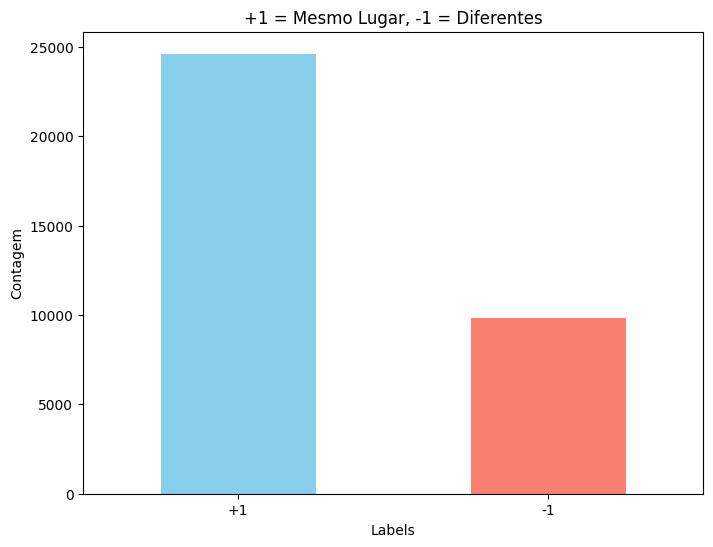

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
label_col.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('+1 = Mesmo Lugar, -1 = Diferentes')
plt.xlabel('Labels')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.show()


#  Separação de Variáveis Numéricas e Categóricas

Para facilitar as análises, dividimos as colunas do dataset em **numéricas** e **categóricas**.

**Observando:**  
- **Modelos de Machine Learning** tratam variáveis numéricas e categóricas de formas diferentes.  
- **Transformações específicas** podem ser aplicadas em cada tipo de dado (ex: normalização para numéricas, dummies para categóricas).  

A correta separação garante um **pré-processamento eficiente** e evita problemas futuros na modelagem.


Colunas numéricas: 89
Colunas categóricas: 30


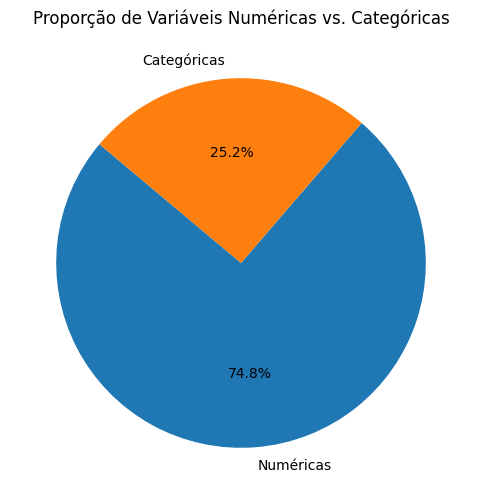

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exemplo de função que checa se, em uma dada coluna, a maioria (ex: 90%) dos valores não-nulos é numérica
def can_be_numeric(series, threshold=0.9):
    # Remove valores ausentes (NaN)
    filtered = series.dropna()
    if len(filtered) == 0:
        # Se a coluna inteira é NaN, você pode decidir considerá-la numérica ou categórica
        # Aqui, por exemplo, vou retornar False (categórica)
        return False
    
    # Conta quantos valores conseguem ser convertidos para float com sucesso
    numeric_count = 0
    for val in filtered:
        try:
            float(val)  # Tenta converter
            numeric_count += 1
        except ValueError:
            pass
    
    # Fracão de valores que foram convertidos com sucesso
    fraction = numeric_count / len(filtered)
    
    # Se a fração de valores convertíveis é maior que o "threshold",
    # consideramos que a coluna é numérica
    return fraction >= threshold

# ----------------------
# 1) Substituir '?' por NaN
nomao_df = nomao_df.replace('?', np.nan)

# 2) Listas de colunas
num_cols = []
cat_cols = []

for col in nomao_df.columns:
    # Se a coluna for convertível para numérico acima do threshold, convertemos
    if can_be_numeric(nomao_df[col], threshold=0.9):
        # Converter oficialmente para float (ou int) no DataFrame
        nomao_df[col] = pd.to_numeric(nomao_df[col], errors='coerce')
        num_cols.append(col)
    else:
        cat_cols.append(col)

# Agora temos duas listas: num_cols (colunas efetivamente numéricas) e cat_cols (colunas categóricas)
print(f"Colunas numéricas: {len(num_cols)}")
print(f"Colunas categóricas: {len(cat_cols)}")

# ----------------------
# 3) Exemplo de gráfico de pizza mostrando a distribuição
labels = ['Numéricas', 'Categóricas']
sizes = [len(num_cols), len(cat_cols)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Variáveis Numéricas vs. Categóricas')
plt.show()


# ⚠️ Analisando Valores Ausentes

Um aspecto crítico na preparação dos dados é lidar com valores ausentes.  
Neste conjunto de dados, os valores faltantes são representados pelo símbolo **`?`**.  

✅ **Aqui, verificamos:**  
- Quais colunas possuem valores ausentes  
- A porcentagem de valores ausentes em cada variável  

Esses insights ajudarão a decidir se devemos imputar valores, remover colunas ou transformar os dados de outra forma.


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Contagem de NaNs por coluna
missing_count = nomao_df.isna().sum().sort_values(ascending=False)

missing_count

fax_trigram                33570
fax_levenshtein            33570
fax_diff                   33570
website_levenshtein_sim    32289
website_intersect_max      32289
                           ...  
website_including              1
street_equality                1
street_including               1
zip_equality                   1
id                             0
Length: 119, dtype: int64

## Outliers

# 🎯 Conclusões da Análise Exploratória

Após explorar o conjunto de dados, podemos concluir que:  

✅ O dataset possui **{total_features}** variáveis e **{total_rows}** registros.  
✅ Existem **{num_missing}** colunas com valores ausentes.  
✅ O dataset contém variáveis **numéricas** e **categóricas**, exigindo diferentes tratamentos.  
✅ Detectamos **{num_outliers}** outliers, que podem precisar de tratamento.  
✅ O balanceamento da variável **label** sugere a necessidade de ajustes no treinamento dos modelos.

Com essas informações, agora podemos prosseguir para o **pré-processamento e modelagem dos dados**!
